## Digital Image Processing, ECE419

Ernesto Colon

The Cooper Union Department of Electrical Engineering

March 13th, 2021

References:
- Digital Image Processing Using Matlab [DIPUM] by Gonzalez et al., 3rd ed
- Digital Image Processing by Gonzalez et al., 4th ed

**The following set of notes and example scripts are part of my independent study sessions and adapted from the
references outlined above. My main reference is DIPUM and complemented with online documentation. As I go through the
theory and textbook examples, I am translating the code and image processing techniques to Python.**

## Image Segmentation Notes / Exercises

In [1]:
# Import libraries
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import ec_img_utils
import skimage.util
from skimage import io
from skimage import morphology
from matplotlib import colors

In this section, we shift our attention from image processing techniques were both the input and output of our system
are images. Instead, we now seek to extract features or attributes from our input images. In particular, we will consider
segmentation, which consists of subdividing our image into regions.

First, we will explore edge detection which is a way to segment an image based on sharp or abrupt transitions in the
image's intensity values. Edge detection can be considered an image segmentation technique based on intensity
discontinuities.

**Some background**

Mathematically, we can represent segmentation as a process that partitions an image into $n$ subregions that satisfy the
following properties, where $R$ is the entire spatial region occupied by the image [DIPUM]:

a) $\bigcup\limits_{i=1}^{n} R_{i} = R$.

b) $R-i$ is a connected set for $i = 0, 1, 2, ..., n$.

c) $R_i \cap R_j = \emptyset$ for all valid values of $i$ and $j$, $i \neq j$.

d) $Q(R_i) = TRUE$ for $i = 0, 1, 2, ..., n$.

e) $Q(R_i \cup R_j) = FALSE$ for all adjacent regions $R_i$ and $R_j$.

Where $Q(R_k)$ is a *logical* *predicate* defined over the elements in the set $R_k$. For example, $Q$ can be a compound
predicate such as: $Q(R_i) = TRUE$ is the average intensity of the pixels in region $R_i$ is less than $m_i$ AND if the
standard deviation of the intensity values is greater than $\sigma_i$.

### Edge Detection

As described previously, edge detection is a form of image segmentation based on intensity discontinuities. In edge
detection, objects or regions in the image are differentiated from the background by detecting their boundaries.

The first and second order derivatives of an image are used to detect the intensity discontinuities. We can compute the
first-order derivative with the gradient operator. The gradient of a 2D function $f(x,y)$ is defined as:

\begin{equation}
\nabla[\boldsymbol{f}(x,y)] =
\begin{bmatrix} g_x \\ g_y \end{bmatrix} =
\begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}
\end{equation}

The magnitude of the gradient is defined as:

\begin{equation}
|\nabla\boldsymbol{f}(x,y)| = [g_x^2 + g_y^2]^{1/2} \approx |g_x| + |g_y|
\end{equation}

and the direction of maximum rate of change can be found as the arctangent of the vertical to the horizontal gradients.
Note that this is a *four-quadrant* arctangent.

\begin{equation}
\alpha(x,y) = tan^{-1}\frac{g_y}{g_x}
\end{equation}

Second-order derivatives for image processing are usually computed using the *Laplacian* operator. The Laplacian of a 2D
function $f(x,y)$ is defined as:

\begin{equation}
\nabla^2\boldsymbol{f}(x,y) = \frac{\partial^2 f}{\partial x^2} f(x,y) + \frac{\partial^2 f}{\partial y^2} f(x,y)
\end{equation}

As described in [DIPUM], the Laplacian of an image is highly sensitive to noise, and its magnitude is prone to producing
double edges. However, it is still used as a pre-processing step in more advanced edge detection algorithms.

#### Sobel Edge Detector

The Sobel edge detector approximates the first-order derivatives as discrete differences in a small pixel neighborhood
as shown below.

\begin{equation}
Neighborhood = \begin{bmatrix}
z_1 & z_2 & z_3\\
z_4 & z_5 & z_6\\
z_7 & z_8 & z_9
\end{bmatrix}
\end{equation}

\begin{equation}
g_x = (z_1 + 2z_2 + z_3) - (z_7 + 2z_8 + z_9)
\end{equation}

\begin{equation}
g_y = (z_1 + 2z_4 + z_7) - (z_3 + 2z_6 + z_9)
\end{equation}

And the corresponding Sobel kernels are as shown below.

\begin{equation}
Sobel_x = \begin{bmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
\end{equation}

\begin{equation}
Sobel_y = \begin{bmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1
\end{bmatrix}
\end{equation}

We can compute the gradient as the square root of the sum in quadrature of the x- and y-gradients as outlined above.

Let's try this out...

**Custom Sobel Edge Detector**

In [2]:
def edge_sobel(img):
    """
    Function to perform edge detection on an input grayscale image using a Sobel kernel
    @param img: ndarray-like grayscale image or channel. This function assumes a single channel image. If RGB is needed,
                individual channels may be computed individually.
    @return:    ndarray-like edge map. Same dimensions as the input image
    """

    # convert image to float, just in case
    img = skimage.img_as_float(img)

    # Compute gradients in x and y direction using a Sobel filter
    grad_x = skimage.filters.sobel(img, axis=0, mode='reflect')
    grad_y = skimage.filters.sobel(img, axis=1, mode='reflect')

    # compute gradient magnitude
    grad = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))

    return grad

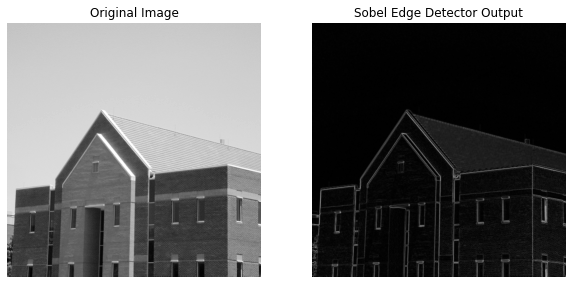

In [3]:
# Test my sobel edge detector
# Load building image
img_building = io.imread('./images/building.tif')

# perform Sobel edge detection
img_build_edge_sob = edge_sobel(img_building)

# display the images
sobel_params = {'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, img_build_edge_sob],
                'titles' : ['Original Image', 'Sobel Edge Detector Output']}

ec_img_utils.gray_img_comparison_plot(sobel_params)

#### Prewitt Edge Detector

The Prewitt edge detector approximates the first-order derivatives as discrete differences in a small pixel neighborhood
as shown below:

\begin{equation}
Neighborhood = \begin{bmatrix}
z_1 & z_2 & z_3\\
z_4 & z_5 & z_6\\
z_7 & z_8 & z_9
\end{bmatrix}
\end{equation}

\begin{equation}
g_x = (z_1 + z_2 + z_3) - (z_7 + z_8 + z_9)
\end{equation}

\begin{equation}
g_y = (z_1 + z_4 + z_7) - (z_3 + z_6 + z_9)
\end{equation}

and the corresponding Sobel kernels are as shown below.

\begin{equation}
Sobel_x = \begin{bmatrix}
1 & 1 & 1\\
0 & 0 & 0\\
-1 & -1 & -1
\end{bmatrix}
\end{equation}

\begin{equation}
Sobel_y = \begin{bmatrix}
1 & 0 & -1\\
1 & 0 & -1\\
1 & 0 & -1
\end{bmatrix}
\end{equation}

We can compute the gradient as the square root of the sum in quadrature of the x- and y-gradients as outlined above.

Let's try it out...

**Custom Prewitt Edge Detector**

In [4]:
def edge_prewitt(img):
    """
    Function to perform edge detection on an input grayscale image using a Prewitt kernel
    @param img: ndarray-like grayscale image or channel. This function assumes a single channel image. If RGB is needed,
                individual channels may be computed individually.
    @return:    ndarray-like edge map. Same dimensions as the input image
    """

    # convert image to float, just in case
    img = skimage.img_as_float(img)

    # Compute gradients in x and y direction using a Sobel filter
    grad_x = skimage.filters.prewitt(img, axis=0, mode='reflect')
    grad_y = skimage.filters.prewitt(img, axis=1, mode='reflect')

    # compute gradient magnitude
    grad = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))

    return grad

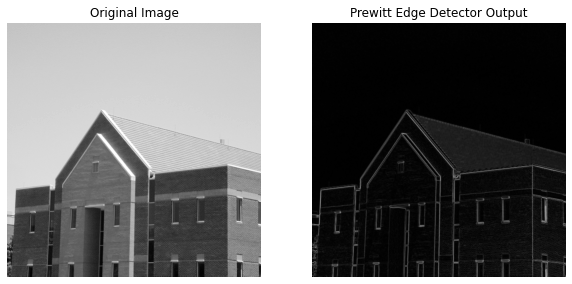

In [5]:
# Test my Prewitt edge detector

# perform Prewitt edge detection
img_build_edge_prewitt = edge_prewitt(img_building)

# display the images
prewitt_params = {'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, img_build_edge_prewitt],
                'titles' : ['Original Image', 'Prewitt Edge Detector Output']}

ec_img_utils.gray_img_comparison_plot(prewitt_params)

Let's compare the Sobel and Prewitt Edge Detectors. Let's compute the absolute difference between the two edge maps

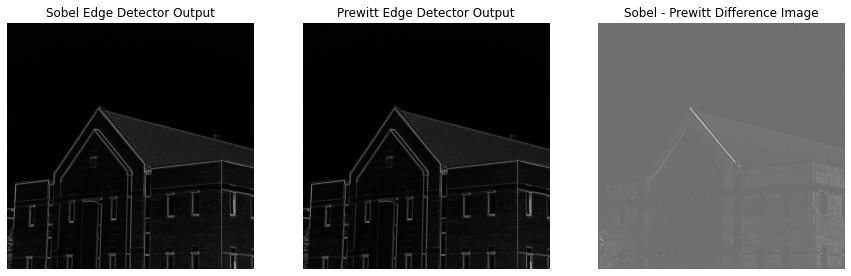

In [6]:
# compute the difference between the Sobel and Prewitt edge detectors
sobel_prewitt_diff = ec_img_utils.normalize_zero_one(img_build_edge_sob - img_build_edge_prewitt)

# display the images
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 3,
                'figsize' : (15, 5),
                'images' : [img_build_edge_sob, img_build_edge_prewitt, sobel_prewitt_diff],
                'titles' : ['Sobel Edge Detector Output', 'Prewitt Edge Detector Output',
                            'Sobel - Prewitt Difference Image']})

Note that even though it is a bit difficult to discern the difference between the Sobel and Prewitt edge maps, they are
indeed different. My approach to visualize the difference consists in computing the difference between the two edge maps
and normalizing the result between [0, 1] to display the results. Note how the diagonal at the top of the building is
very prominent in the difference image. Also, not how we the outer walls of the building are clearly visible in the
difference image. This indicates that our edge map is not just outlining the building boundary, but it also contains
local details that we may not be interested in. We'll see more robust techniques later.
